In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from hat.models import HumanAttnTransformer
from common.config import JsonConfig
from torchvision import transforms
from PIL import Image
from hat.evaluation import scanpath_decode
from matplotlib.patches import Rectangle

/home/zbyang/miniconda3/envs/cuda11.7/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [88]:
# choose configs
TAP = 'TP' # ["TP", "TA", "FV"]

if TAP == 'TP':
    # Target-present visual search (TP)
    hparams = JsonConfig('configs/coco_search18_dense_SSL_TP.json')
elif TAP == 'TA':
    # Target-absent visual search (TA)
    hparams = JsonConfig('configs/coco_search18_dense_SSL_TA.json')
elif TAP == 'FV': 
    # Free viewing (FV)
    hparams = JsonConfig('configs/coco_freeview_dense_SSL.json')
else:
    raise NotImplementedError

In [ ]:
# Download checkpoints if needed
import wget
import os

if not os.path.exists(f"./checkpoints/HAT_{TAP}.pt"):
    if not os.path.exists("./checkpoints/"):
        os.mkdir('./checkpoints')

    print('downloading model checkpoint...')
    url = f"http://vision.cs.stonybrook.edu/~cvlab_download/HAT/HAT_{TAP}.pt"
    wget.download(url, 'checkpoints/')

if not os.path.exists(f"./pretrained_models/M2F_R50_MSDeformAttnPixelDecoder.pkl"):
    if not os.path.exists("./pretrained_models/"):
        os.mkdir('./pretrained_models')

    print('downloading pretrained model weights...')
    url = f"http://vision.cs.stonybrook.edu/~cvlab_download/HAT/pretrained_models/M2F_R50_MSDeformAttnPixelDecoder.pkl"
    wget.download(url, 'pretrained_models/')
    url = f"http://vision.cs.stonybrook.edu/~cvlab_download/HAT/pretrained_models/M2F_R50.pkl"
    wget.download(url, 'pretrained_models/')

In [95]:
# create model
model = HumanAttnTransformer(
    hparams.Data,
    num_decoder_layers=hparams.Model.n_dec_layers,
    hidden_dim=hparams.Model.embedding_dim,
    nhead=hparams.Model.n_heads,
    ntask=1 if hparams.Data.TAP == 'FV' else 18,
    tgt_vocab_size=hparams.Data.patch_count + len(hparams.Data.special_symbols),
    num_output_layers=hparams.Model.num_output_layers,
    separate_fix_arch=hparams.Model.separate_fix_arch,
    train_encoder=hparams.Train.train_backbone,
    train_pixel_decoder=hparams.Train.train_pixel_decoder,
    use_dino=hparams.Train.use_dino_pretrained_model,
    dropout=hparams.Train.dropout,
    dim_feedforward=hparams.Model.hidden_dim,
    parallel_arch=hparams.Model.parallel_arch,
    dorsal_source=hparams.Model.dorsal_source,
    num_encoder_layers=hparams.Model.n_enc_layers,
    output_centermap="centermap_pred" in hparams.Train.losses,
    output_saliency="saliency_pred" in hparams.Train.losses,
    output_target_map="target_map_pred" in hparams.Train.losses,
    transfer_learning_setting=hparams.Train.transfer_learn,
    project_queries=hparams.Train.project_queries,
    is_pretraining=False,
    output_feature_map_name=hparams.Model.output_feature_map_name)

Config './configs/resnet50.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Loaded backbone weights from pretrained_models/M2F_R50.pkl
Loaded MSD pixel decoder weights from pretrained_models/M2F_R50_MSDeformAttnPixelDecoder.pkl


In [96]:
# load checkpoint
# before proceed, please make sure to download checkpionts from http://vision.cs.stonybrook.edu/~cvlab_download/HAT/

checkpoint_pahts = {
    'TP': "./checkpoints/HAT_TP.pt", # target present
    'TA': "./checkpoints/HAT_TA.pt", # target absent
    'FV': "./checkpoints/HAT_FV.pt" # free viewing
}
ckpt = torch.load(checkpoint_pahts[hparams.Data.TAP], map_location='cpu')
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

(-0.5, 511.5, 319.5, -0.5)

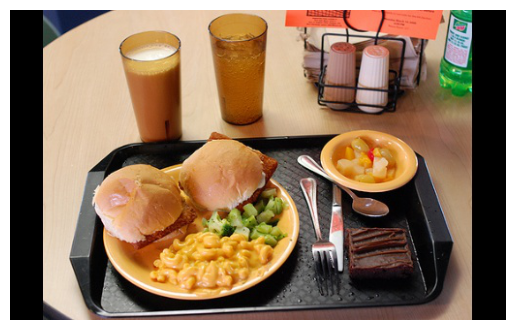

In [97]:
%matplotlib inline
# load test image
img = Image.open('./demo/test.jpg')

plt.imshow(img)
plt.axis('off')

In [98]:
# preprocess
size = (hparams.Data.im_h, hparams.Data.im_w)
transform = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = torch.unsqueeze(transform(img), 0)

# Load preset task name and ids
preset_tasks = np.load("./demo/all_task_ids.npy", allow_pickle=True).item()

In [99]:
# utility functions
def plot_scanpath(img, xs, ys, bbox=None, title=None):
    fig, ax = plt.subplots()
    ax.imshow(img)
    cir_rad = 15

    for i in range(len(xs)):
        if i > 0:
            plt.arrow(xs[i - 1], ys[i - 1], xs[i] - xs[i - 1],
                      ys[i] - ys[i - 1], width=3, color='yellow', alpha=0.5)

    for i in range(len(xs)):
        
        circle = plt.Circle((xs[i], ys[i]),
                            radius=cir_rad,
                            edgecolor='red',
                            facecolor='yellow',
                            alpha=0.5)
        ax.add_patch(circle)
        plt.annotate("{}".format(
            i+1), xy=(xs[i], ys[i]+3), fontsize=10, ha="center", va="center")

    if bbox is not None:
        rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
            alpha=0.5, edgecolor='yellow', facecolor='none', linewidth=2)
        ax.add_patch(rect)

    ax.axis('off')
    if title is not None:
        ax.set_title(title)
    plt.show()
    
def actions2scanpaths(norm_fixs, im_h, im_w):
    # convert actions to scanpaths
    scanpaths = []
    for fixs in norm_fixs:
        fixs = fixs.numpy()
        scanpaths.append({
            'X': fixs[:, 0] * im_w,
            'Y': fixs[:, 1] * im_h,
        })
    return scanpaths

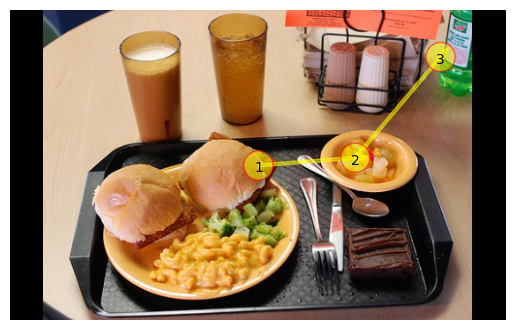

In [100]:
task = 'bottle'
sample_action = False
if task in preset_tasks and TAP != 'FV':
    task_id = torch.tensor([preset_tasks[task]], dtype=torch.long)
else:
    task_id = torch.tensor([0], dtype=torch.long)
normalized_sp, _ = scanpath_decode(model, img_tensor, task_id, hparams.Data, sample_action=sample_action, center_initial=True)
scanpath = actions2scanpaths(normalized_sp, hparams.Data.im_h, hparams.Data.im_w)[0]

plot_scanpath(img, scanpath['X'], scanpath['Y'])